# Capstone: West Nile Virus
## Challenge
 
West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, we are asked to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns',1000)

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

##### Training and Test data:
The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set we are requested 
to predict the test results for 2008, 2010, 2012, and 2014.

In [2]:
train = pd.read_csv('./datasets/train.csv')

# Make Date into datetime object, and index:
train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')
train.set_index('Date', inplace=True, drop=True)
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [3]:
train[train.index=='2007-05-29'].shape

(25, 11)

In [4]:
test = pd.read_csv('./datasets/test.csv')
# Make Date into datetime object, and index
test['Date'] = pd.to_datetime(test.Date, format='%Y-%m-%d')
test.set_index('Date', inplace=True, drop=True)
test.head(1)

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


##### Weather Data:
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. 
We are provided with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of
the tests. 
    Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
    Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [159]:
weather = pd.read_csv('./datasets/weather.csv')
# Make Date into datetime object, and index
weather['Date'] = pd.to_datetime(weather.Date, format='%Y-%m-%d')
weather.set_index('Date', inplace=True, drop=True)

# Data Cleaning:
weather['Tavg'] = pd.to_numeric(weather.apply(lambda x: (x['Tmin']+x['Tmax'])/2, axis=1))
weather['PrecipTotal'] = pd.to_numeric(weather.apply(lambda x: 0 if x['PrecipTotal']=='  T' or x['PrecipTotal']=='M' else x['PrecipTotal'], axis=1))

# Add Long / Lat:
weather.insert(1,'Latitude', weather.apply(lambda x: 41.995 if x['Station']==1 else 41.786, axis=1))
weather.insert(2,'Longitude', weather.apply(lambda x: -87.933 if x['Station']==1 else -87.752, axis=1))

weather.head(1)

,Station,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2


In [162]:
# save to csv for import into Tableau
weather.to_csv(r'./datasets/weather_map.csv')

##### Spray Data

The City of Chicago also does spraying to kill mosquitos. We are given the GIS data for their spray efforts
in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

In [6]:
spray = pd.read_csv('./datasets/spray.csv')
# Make Date into datetime object, and index
spray['Date'] = pd.to_datetime(spray.Date, format='%Y-%m-%d')
spray.set_index('Date', inplace=True, drop=True)
spray.drop(columns='Time', inplace=True)
spray.head(1)

,Latitude,Longitude
Date,,
2011-08-29,42.391623,-88.089163


## EDA

In [7]:
# To-Do:
    # 1. Fitting classifiers on training data:
    # 2. Can I find correct test data to test this against?

In [8]:
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [51]:
y, X = train['WnvPresent'], train['Trap']
X_dum = pd.get_dummies(X, drop_first=True)
lr = LogisticRegression(C=10**10, fit_intercept=False, max_iter=10000)
lr.fit(X_dum,y)

ts = TimeSeriesSplit(n_splits=5)
ts.split(X_dum)
print('CV score:', cross_val_score(lr, X_dum, y, cv=ts).mean())

CV score: 0.9423186750428327


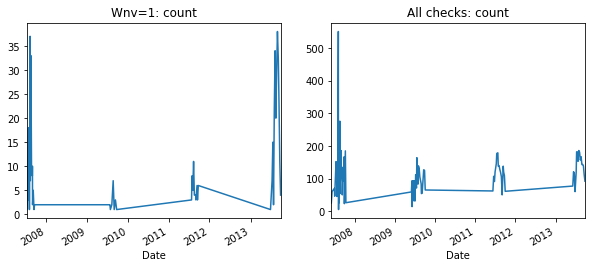

In [127]:
# strong seasonal effects according to WnvPresent timeline of incidence, summer = more Wnv:
# interestingly 2007 and 2013 had far higher incidences than the intervening years.
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
train[train['WnvPresent']==1]['WnvPresent'].groupby('Date').count().plot(ax=ax[0], title='Wnv=1: count')
train['WnvPresent'].groupby('Date').count().plot(ax=ax[1], title='All checks: count');

# comparing this plot to the one above, we see there were fewer tests overall in the intervening years, and more
# tests in 2013 coupled with higher rate of positives, why?
    # Was Chicago starting to predict better the WNV's whereabouts?
    # Did weather mean there were more mosquitos and therefore more WNV in 2007 and 2013 vs. other times?

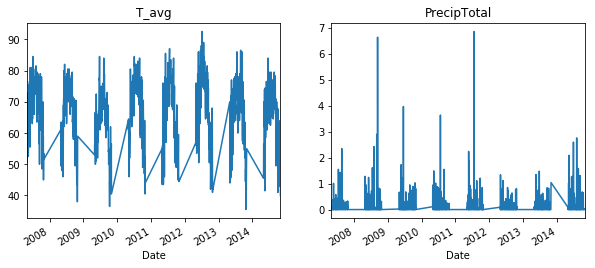

In [128]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
pd.to_numeric(weather[(weather['Station']==1)].Tavg).plot(ax=ax[0], title='T_avg')
pd.to_numeric(weather[(weather['Station']==1)].PrecipTotal).plot(ax=ax[1], title='PrecipTotal');

# Tavg is pretty steady across the time period, but interestingly precipitation was higher in those years that
# fewer cases of Wnv were found, perhaps an explainer?
    # We will add these two columns to train data:

In [133]:
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
